## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [ ]:
df= pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [ ]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [ ]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [ ]:
conv= df.query('converted==1')
conv_prop= len(conv)/len(df)
conv_prop

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [ ]:
df.groupby(['group','landing_page']).size()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64

In [ ]:
new_page= df[df.landing_page=="new_page"]
len(df.query('group=="treatment" & landing_page=="old_page"') + df.query('group=="control" & landing_page=="new_page"'))

3893

f. Do any of the rows have missing values?

In [ ]:
df.isnull().sum()


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

>*There's no missing data*

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [ ]:
df2= df.drop(df[(df.group =='treatment') & (df.landing_page== 'old_page')].index)
df2.drop(df[(df.group =='control') & (df.landing_page== 'new_page')].index, inplace=True)
df2.shape

(290585, 5)

In [ ]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [ ]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [ ]:
df2['user_id'].value_counts().head(1)

773192    2
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [ ]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [ ]:
df2.drop(df2[df2['user_id'].duplicated()].index, inplace=True)
sum(df2['user_id'].duplicated())

0

In [ ]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [ ]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [ ]:
df2[df2['group']=="control"].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [ ]:
df2[df2['group']=="treatment"].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [ ]:
# sim= df['landing_page'].replace(['new_page','old_page'], [1,0])
# sim.unique()
# sim.mean()
#OR:

(df2['landing_page']=="new_page").mean()

0.50006194422266881

In [ ]:
(df2[df2['converted']==1].group=='treatment').mean()

0.49676286939257042

In [ ]:
(df2[df2['converted']==1].group=='control').mean()

0.50323713060742958

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Seems like there's no relationship between the new treatment page and getting more conversions,there is no sufficient evidence to conclude so..**

<a id='ab_test'></a>
### Part II - A/B Test


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$** : **$p_{new}$** - **$p_{old}$** <= 0

**$H_{1}$** : **$p_{new}$** - **$p_{old}$** > 0

In [ ]:
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [ ]:
sample1= df.sample(147239, replace=True)

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [ ]:
pnew=df['converted'].mean()
pnew

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [ ]:
p_old=df['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [ ]:
n_new= df2[df2['group']=="treatment"].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [ ]:
n_old= df2[df2['group']=="control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [ ]:
new_page_converted= np.random.choice([1,0], n_new, replace=True,p=[pnew,1-pnew])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [ ]:
old_page_converted= np.random.choice([1,0], n_old, replace=True,p=[p_old,1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [ ]:
new_page_converted.mean() - old_page_converted.mean()

-0.00052520850097158289

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [ ]:
p_diffs=[]
for _ in range(10000):
    new_page_converted= np.random.choice([1,0], n_new, replace=True,p=[pnew,1-pnew])
    old_page_converted= np.random.choice([1,0], n_old, replace=True,p=[p_old,1-p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

p_diffs=np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

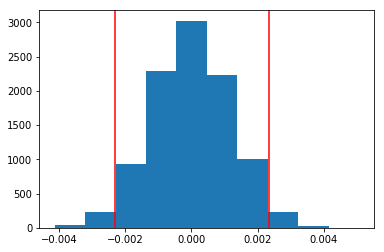

In [ ]:
lower, upper= np.percentile(p_diffs,2.5), np.percentile(p_diffs, 97.5)
plt.hist(p_diffs);
plt.axvline(x=lower, color='red');
plt.axvline(x=upper, color='red');

> *This looked almost exactly like I expected; that is, the plot is normally distributed, and our interval was satisfying the null hypothesis **((mean differences are less than or equal to 0))**.*

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [ ]:
actual_mean_diff= df2[df2['landing_page']=="new_page"].converted.mean() - df2[df2['landing_page']=="old_page"].converted.mean()
actual_mean_diff

-0.0015782389853555567

In [ ]:
null_vals= np.random.normal(0,p_diffs.std(),10000)
(null_vals> actual_mean_diff).mean()

0.90759999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **We have just computed the P-Value, which is: "the probability of finding the observed, or more extreme, results when the null hypothesis is true".**

> Here our **P_Value "0.9"** happens to be **greater than** the Type1 error rate **Alpha "0.05"**, which means "*we fail to reject the null hypothesis"* (differences in conversion rates for old and new pages are less than or equal to 0 ) . That is, **the new page shouldn't be considered better than the old one..**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

convert_old = df2[df2['group']=="control"].converted.sum()
convert_new = df2[df2['group']=="treatment"].converted.sum()
n_old = df2[df2['group']=="control"].shape[0]
n_new = df2[df2['group']=="treatment"].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [ ]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 0 ,alternative='larger')
stat, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The results agree with the previous findings as The z-score and p-value lead to the same conclusion of parts "j and k"; our p-value (0.9) is greater than the value of alpha (0.05), which suggests that our statistic is likely to come from the null hypothesis. Thus, we fail to reject the null hypothesis ,so there is a significant evidence that the new page is no better than the old one.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should be using Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [ ]:
import statsmodels.api as sm
df2['intercept']=1
df2['ab_page']= pd.get_dummies(df2['group'])['treatment']

df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [ ]:
log_mod= sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res= log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 19:23 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>**ab_page has a P-value of (0.189), the reason why it differs from the value found in Part II is that our new hypothesises are no more checking if there's a difference in the conversion rates depending on page types, rather it is checking if the "ab_page" variable is considered statistically significant in predecting wheather an individual is converting or not**

>**Based on our P-value, we can say that wheather an individual receives the treatment page or not is not going to make a significant difference in predicting if they are going to become converted or not "the null hypothesis"**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**We should consider other factors into the regression model as they can have an effect on the conversions too. For instance, the duration of time an individual spends on the website may have a relationship with them being converted. Another aspect is that of segments of users might create "change aversion" or  "navelty effect".**

>**Yes, there might be disadvantages of adding additional terms into the regression model, like causing a multicoliniarity..**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
countries= pd.read_csv('countries.csv')
countries.head()
countries[countries['user_id']==851104]
countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [ ]:
df3=df2.join(countries.set_index('user_id'), on='user_id')
dummy= pd.get_dummies(df3['country'])
df3= df3.join(dummy)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [ ]:
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'US','UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 20:59 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

**We still can conclude that even the country in which a user lives is not considered of a statistical significance in predicting whether they will convert or not, as both of our p-values of the provided cities are still greater than the alpha value..**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
df3['page_UK'] = df3['ab_page'] * df3['UK']
df3['page_US'] = df3['ab_page'] * df3['US']
model= sm.Logit(df3['converted'],df3[['intercept','page_UK','page_US','UK','US','ab_page']])
res= model.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-02-14 21:14 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
page_UK        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
page_US        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
==================================================================

"""

>We can also still conclude based on our p-values that the interaction between the page type an individual receives and the country they live in does not have an impact on the conversion rate

***Finally, we can conclude that non of the provided features is actually statisctically significant in predicting whether an individual would convert or not..***

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0